**Project 4** - Group 2 (Emma, Gabriel, Ben, Junhao)

<br>

<font size="6">Part 2: Modelling

## Load Libraries / Import Datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from geopy.distance import geodesic

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix,
    accuracy_score,
    plot_roc_curve,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier

pd.set_option('display.max_colwidth', 0)

In [5]:
train_weather = pd.read_csv(r'../datasets/train_weather_v3.csv')
test_weather = pd.read_csv(r'../datasets/test_weather_v3.csv')
submission = pd.read_csv(r'../datasets/sampleSubmission.csv')

The cleaned test dataset has ~13 times more entries than the train dataset.

In [3]:
train_weather.shape

(8475, 28)

In [4]:
test_weather.shape

(116293, 28)

## Functions

In [9]:
def get_model(model, gridcv, pipe_params={}):
    '''Function to apply GriSearchCV based on selected model and parameters'''
    
    #Scale X
    ss = StandardScaler()
    Xsc_train = ss.fit_transform(X_train)
    Xsc_test = ss.transform(X_test)
    
    #Models to test
    models = {'lr': LogisticRegression(),
              'nb': MultinomialNB(),
              'rf': RandomForestClassifier(),
              'et': ExtraTreesClassifier(),
              'ada': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
              'knn': KNeighborsClassifier(),
              'gb': GradientBoostingClassifier(),
              'xgb': xgb.XGBClassifier()
             }
    
    #pipeline to include SMOTE since this is an unbalanced dataset 
    pipe = imbpipeline([
        ('sm', SMOTE(random_state=42)), 
        (model, models[model]),
            ])
    
    pipe_params = pipe_params
    
    #GriSesarchCV on user assigned parameters
    gridsearch = GridSearchCV(pipe, pipe_params, cv=gridcv, scoring='roc_auc', verbose=1, n_jobs=-1)
    
    gridsearch.fit(Xsc_train, y_train)
    
    #predict on test 
    preds = gridsearch.predict(Xsc_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    model_probs_train = gridsearch.predict_proba(Xsc_train)[:, 1]
    model_probs_test = gridsearch.predict_proba(Xsc_test)[:, 1]
    roc_auc = cross_val_score(pipe, Xsc_train, y_train, scoring='roc_auc', cv=gridcv)
    best_params = gridsearch.best_params_
    
    #Metrics to produce
    summary ={
        'model': model,
        'accuracy': accuracy_score(y_test, preds),
        'specificity': tn / (tn+fp),
        'recall': recall_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'AUC_CV': roc_auc.mean(),
        'AUC_train': roc_auc_score(y_train, model_probs_train),
        'AUC_test': roc_auc_score(y_test, model_probs_test),
        'best params': best_params}
    
    summary_df = pd.DataFrame.from_dict(summary, orient='Index', columns=[str(model)])

    return summary_df

## Modelling

In this section, we will train our dataset over 6 different models and evaluate them based on:
- ROC AUC score
- Recall and Precision (F1 score)

In [10]:
#Train/Test(aka Validation) split on Train dataset 

X = train_weather.drop(columns=['WnvPresent'])
y = train_weather['WnvPresent'] 
    
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

metrics = pd.DataFrame(index=[0])

### Baseline 

For the baseline model, we run it a logistic regression model with no parameter tuning. It produced a ROC_AUC test score of 0.81. 

*Note: We have encountered multiple convergence warning messages when running the logistic regression model. Despite adjusting max_iter, it has no effect on eliminating this error message. We have inspected our train/test scores, which look ok, and we have decided to proceed as such.*

In [7]:
get_model('lr', 5, pipe_params={})

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

,lr
model,lr
accuracy,0.73714
specificity,0.735661
recall,0.763158
precision,0.141005
f1_score,0.23803
AUC_CV,0.833047
AUC_train,0.844657
AUC_test,0.817988
best params,{}


### Logistic Regression

In [8]:
%%time

lr_results = get_model('lr', 5, pipe_params={
    'lr__C' : np.logspace(0.01, 1, 10),
    'lr__solver': ['sag','saga', 'liblinear'],    
    'lr__max_iter': [1000, 5000, 10000]
})

lr_results

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

CPU times: user 4.92 s, sys: 180 ms, total: 5.1 s
Wall time: 4min 4s


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

,lr
model,lr
accuracy,0.73714
specificity,0.735661
recall,0.763158
precision,0.141005
f1_score,0.23803
AUC_CV,0.833047
AUC_train,0.844653
AUC_test,0.817984
best params,"{'lr__C': 1.023292992280754, 'lr__max_iter': 1000, 'lr__solver': 'saga'}"


### Random Forest

In [12]:
%%time

rf_results = get_model('rf', 5, pipe_params={
    'rf__n_estimators': [100, 150, 200],
    'rf__min_samples_split': [2, 3, 5],
    'rf__min_samples_leaf': [2, 5]
})

rf_results

Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 9.11 s, sys: 168 ms, total: 9.28 s
Wall time: 35.1 s


,rf
model,rf
accuracy,0.90184
specificity,0.931172
recall,0.385965
precision,0.241758
f1_score,0.297297
AUC_CV,0.761421
AUC_train,0.937813
AUC_test,0.814715
best params,"{'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 100}"


### K Nearest Neighbors

In [13]:
%%time

knn_results = get_model('knn', 5, pipe_params={
    'knn__leaf_size': [10, 20, 30],
    'knn__n_neighbors': [10, 25, 50, 75],
    'knn__p': [1, 2]
})

knn_results

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 9.32 s, sys: 1.44 s, total: 10.8 s
Wall time: 18.4 s


,knn
model,knn
accuracy,0.746579
specificity,0.74813
recall,0.719298
precision,0.139693
f1_score,0.233951
AUC_CV,0.729757
AUC_train,0.904566
AUC_test,0.784709
best params,"{'knn__leaf_size': 10, 'knn__n_neighbors': 50, 'knn__p': 1}"


### GradientBoost

In [11]:
%%time

gb_results = get_model('gb', 5, pipe_params={
    'gb__max_depth': [3,5],
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [.05, .1, .15],
    'gb__min_samples_leaf':[10,15],
    'gb__min_samples_split':[10, 15],
})

gb_results

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 14.5 s, sys: 465 ms, total: 15 s
Wall time: 7min 56s


,gb
model,gb
accuracy,0.879188
specificity,0.901247
recall,0.491228
precision,0.220472
f1_score,0.304348
AUC_CV,0.837709
AUC_train,0.894464
AUC_test,0.828094
best params,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__min_samples_leaf': 10, 'gb__min_samples_split': 15, 'gb__n_estimators': 150}"


### AdaBoost

In [16]:
%%time

ada_results = get_model('ada', 5, pipe_params={
    'sm__k_neighbors': [20, 50, 80], 
    'ada__n_estimators': [30, 50, 80],
    'ada__learning_rate': [0.1, 0.3, 0.7, 1],
    'ada__base_estimator__max_depth': [1, 2] 
})

ada_results

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 12.7 s, sys: 232 ms, total: 12.9 s
Wall time: 1min 17s


,ada
model,ada
accuracy,0.934403
specificity,0.981047
recall,0.114035
precision,0.254902
f1_score,0.157576
AUC_CV,0.713697
AUC_train,0.893912
AUC_test,0.830113
best params,"{'ada__base_estimator__max_depth': 2, 'ada__learning_rate': 0.3, 'ada__n_estimators': 80, 'sm__k_neighbors': 50}"


### XGBoost

In [36]:
xgb_results = get_model('xgb', 5, pipe_params={
    'xgb__use_label_encoder' : [False],
    'xgb__subsample' : [1, 0.5],
    'xgb__colsample_bytree' : [1, 0.75],
    'xgb__learning_rate' : [0.17, 0.1],
    'xgb__min_child_weight': [1, 3],
    'xgb__max_depth' : [3],
    'xgb__n_estimators' : [300, 100],
    'xgb__reg_alpha' : [5, 1, 10],
    'xgb__reg_lambda' : [35, 10, 50],
    'xgb__gamma' : [0.05, 0.1],
    'xgb__objective' : ['binary:logistic']})

xgb_results

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[13:34:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/benjaminpoh/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,xgb
model,xgb
accuracy,0.873997
specificity,0.895761
recall,0.491228
precision,0.211321
f1_score,0.295515
AUC_CV,0.833137
AUC_train,0.903746
AUC_test,0.839701
best params,"{'xgb__colsample_bytree': 1, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.17, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 300, 'xgb__objective': 'binary:logistic', 'xgb__reg_alpha': 10, 'xgb__reg_lambda': 50, 'xgb__subsample': 0.5, 'xgb__use_label_encoder': False}"


## Summary

Overall, we chose the Gradient Boost model. 
- Even though the ADA Boost model provided the best AUC score, it performs poorly in terms of recall and has the lowest F1 score.
- On the other hand, the Gradient Boost model has the 2nd best AUC score @ 82.8% and have the best F1 score. This is represented by fairly balanced recall and precision scores.
- In addition, we are trying to reduce false negatives (we want to avoid predicting 'no WNV' incorrectly), hence choosing the Gradient Boost over ADA Boost was an obvious decision since it has a much higher recall score (49% vs 11%)

In [105]:
overall_df = pd.concat([lr_results, rf_results, knn_results, gb_results, ada_results], axis=1).T
overall_df.sort_values(ascending=False, by='AUC_test').drop(columns=['model'])

,accuracy,specificity,recall,precision,f1_score,AUC_CV,AUC_train,AUC_test,best params
ada,0.934403,0.981047,0.114035,0.254902,0.157576,0.713697,0.893912,0.830113,"{'ada__base_estimator__max_depth': 2, 'ada__learning_rate': 0.3, 'ada__n_estimators': 80, 'sm__k_neighbors': 50}"
gb,0.879188,0.901247,0.491228,0.220472,0.304348,0.837726,0.894464,0.828094,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__min_samples_leaf': 10, 'gb__min_samples_split': 15, 'gb__n_estimators': 150}"
lr,0.73714,0.735661,0.763158,0.141005,0.23803,0.833047,0.844653,0.817984,"{'lr__C': 1.023292992280754, 'lr__max_iter': 1000, 'lr__solver': 'saga'}"
rf,0.90184,0.931172,0.385965,0.241758,0.297297,0.761421,0.937813,0.814715,"{'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 100}"
knn,0.746579,0.74813,0.719298,0.139693,0.233951,0.729757,0.904566,0.784709,"{'knn__leaf_size': 10, 'knn__n_neighbors': 50, 'knn__p': 1}"


In [12]:
ss = StandardScaler()
Xsc_train = ss.fit_transform(X_train)
Xsc_test = ss.transform(X_test)

pipe = imbpipeline([
                ('sm', SMOTE(random_state=42)), 
                ('gb', GradientBoostingClassifier()),
            ])

pipe_params = {
    'gb__learning_rate': [0.1], 
    'gb__max_depth': [3], 
    'gb__min_samples_leaf': [10], 
     'gb__min_samples_split': [15], 
     'gb__n_estimators': [150]
}
    
#GriSesarchCV on user assigned parameters
gb_gridsearch = GridSearchCV(pipe, pipe_params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    
gb_gridsearch.fit(Xsc_train, y_train)

gb_preds = gb_gridsearch.predict(Xsc_test)
tn, fp, fn, tp = confusion_matrix(y_test, gb_preds).ravel()

gb_model_probs_train = gb_gridsearch.predict_proba(Xsc_train)[:, 1]
gb_model_probs_test = gb_gridsearch.predict_proba(Xsc_test)[:, 1]
gb_roc_auc = cross_val_score(pipe, Xsc_train, y_train, scoring='roc_auc', cv=5)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


### ROC-AUC curve

We plot an ROC-AUC curve which measures the model's performance at different thresholds.  The false positive rate located on the x-axis represents the proportion of samples that had no WMV that were incorrectly classified, while the true positive rate, located on the y-axis, represents the proportion of WMV samples that were correctly classified. 

The baseline (dotted orange line) shows that the false positive rate is equivalent to the true positive rate. The area under the curve (baseline) is equivalent to 0.5. 

The gradient boost model attained an AUC score of 0.83, higher than the baseline model and the other models mentioned above, validating its higher predictive ability to distinguish between classes. 

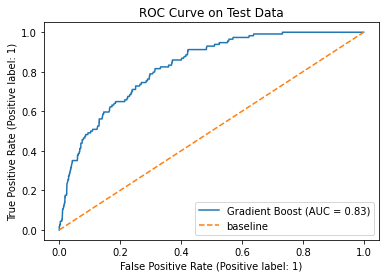

In [15]:
plot_roc_curve(gb_gridsearch, Xsc_test, y_test, name='Gradient Boost')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.title('ROC Curve on Test Data') 
plt.legend();

### Confusion Matrix

Next, we plot a confusion matrix. 
The x-axis reflects the predicted class while the y-axis reflects the actual class. 

As can be seen below, the gradient boost model performs somewhat poorly on identifying the presence of WMV when WMV is present. There were 58 instances where WMV was incorrectly predicted to be absent.  In contrast, there were only 56 instances where WMV was correctly predicted to be present. This ties back to the poorer recall (0.491228) and precision scores (0.304348) observed above. Nevertheless, it should be noted that the chosen GB model scored better than at least 2 of the other models on these scores.  Reducing the number of false negatives and improving the true positives would lend the model a higher predictive ability.  Perhaps this could be done by training with more data (e.g. more data on spray besides the 10 day worth of spray data, data on WMV presence a day after spray etc) and other features that were not provided in the dataset.    

In contrast the model is able to predict 90% of the time that WMV is absent when it is absent. (1807 correctly predicted WMV absent cases out of 2005 WMV absent cases).  It incorrectly predicts 198 WMV absent cases. 

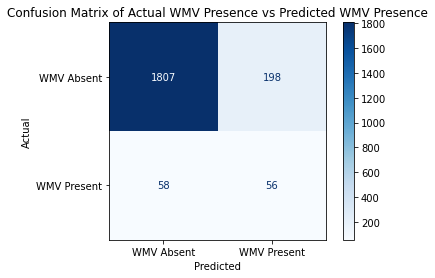

In [14]:
plot_confusion_matrix(gb_gridsearch, Xsc_test, y_test,cmap='Blues', 
                      values_format='d', 
                      display_labels=["WMV Absent", "WMV Present"])
plt.title("Confusion Matrix of Actual WMV Presence vs Predicted WMV Presence")
plt.xlabel('Predicted')
plt.ylabel('Actual');

### Feature Analysis

Feature importance indicates the relative importance of each feature when making a prediction. 

Feature importance scores for all features were relatively conservative (below 0.3). "August" (0.282), "Tavg" (0.102), "AvgSpeed" (0.076), species "Culex Restuans" (0.071) and "DewPoint" (0.064) had the highest feature importance. These results are not surprising. in the EDA notebook, features "Tavg"(0.08), "DewPoint"(0.069), "Culex Restuans"(-0.094) and "AvgSpeed"(-0.089) were observed to have higher absolute correlation with WMV.  

In [23]:
feature_importance = pd.DataFrame(gb_gridsearch.best_estimator_.steps[1][1].feature_importances_, index = X_train.columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature_importance

,Feature Importance
mth_8,0.282638
Tavg,0.103056
AvgSpeed,0.075767
CULEX RESTUANS,0.070716
mth_9,0.064159
DewPoint,0.063627
DewPoint very_high_risk,0.057432
relative_humidity,0.055738
medium_risk,0.055286
high_risk,0.039160


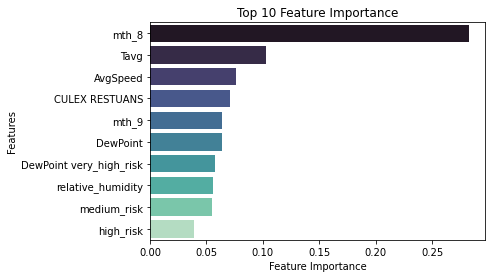

In [48]:
## Plot top 10 feature importance
top_10 = feature_importance.head(10)
plt.figure(figsize=(4,7))
sns.barplot(y=top_10.index,x="Feature Importance", data=top_10, palette = 'mako')
plt.title('Top 10 Feature Importance')
plt.ylabel('Features');

## Kaggle Model

The model that we have decided to use is the Gradient Boost model and these are the parameters which we will use to run our predictions on for the Kaggle competition. We obtained a Kaggle score of nearly 70%.



In [21]:
#Import full train and test dataset

X_full_train = train_weather.drop(columns=['WnvPresent'])
X_full_test = test_weather.drop(columns=['Id'])
y_full_train = train_weather['WnvPresent']


In [145]:
ss = StandardScaler()
X_full_train_sc = ss.fit_transform(X_full_train)
X_full_test_sc = ss.transform(X_full_test)

pipe = imbpipeline([
                ('sm', SMOTE(random_state=42)), 
                ('gb', GradientBoostingClassifier()),
            ])

pipe_params = {
    'gb__learning_rate': [0.1], 
    'gb__max_depth': [3], 
    'gb__min_samples_leaf': [10], 
     'gb__min_samples_split': [15], 
     'gb__n_estimators': [150]
}
    
gridsearch = GridSearchCV(pipe, pipe_params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    
gridsearch.fit(X_full_train_sc, y_full_train)
    
preds = gridsearch.predict_proba(X_full_test_sc)
best_params = gridsearch.best_params_

model_probs_train = gridsearch.predict_proba(X_full_train_sc)[:, 1]
model_probs_test = gridsearch.predict_proba(X_full_test_sc)[:, 1]
roc_auc = cross_val_score(pipe, X_full_train_sc, y_full_train, scoring='roc_auc', cv=5)

summary_final ={
        'model': 'Gradient Boost',
        'AUC_CV': roc_auc.mean(),
        'best params': best_params}


summary_final_df = pd.DataFrame.from_dict(summary_final, orient='Index', columns=['Gradient Boost'])
summary_final_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Gradient Boost
model,Gradient Boost
AUC_CV,0.621277
best params,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__min_samples_leaf': 10, 'gb__min_samples_split': 15, 'gb__n_estimators': 150}"


In [146]:
#Put prediceted 'WnvPresent' into dataframe

predict_y=pd.DataFrame(preds[:,1])
predict_y =predict_y.rename(columns={0:'WnvPresent'})

In [147]:
submission = pd.read_csv(r'../datasets/sampleSubmission.csv')
submission['WnvPresent'] = predict_y['WnvPresent']

In [148]:
submission.to_csv(r'../datasets/sampleSubmission_final.csv', index=False)

<img src="https://i.imgur.com/QVKISnG.png" style="float: center; margin: 20px; height: 400px">